In [1]:
import os
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2 as cv
import random
import numpy as np
import pandas as pd
import time
import tracemalloc
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor,AutoConfig, MobileViTForImageClassification

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
100% 3.58G/3.58G [00:51<00:00, 114MB/s]
100% 3.58G/3.58G [00:51<00:00, 74.6MB/s]


In [4]:
import zipfile
dataset = '/content/real-life-violence-situations-dataset.zip'
with zipfile.ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted.")

The dataset is extracted.


In [5]:
import os

# Replace this with your actual dataset path
dataset_path = "/content/real life violence situations"

for root, dirs, files in os.walk(dataset_path):
    print(f"Current Directory: {root}")
    for d in dirs:
        print(f"  └── Subfolder: {d}")

Current Directory: /content/real life violence situations
  └── Subfolder: Real Life Violence Dataset
Current Directory: /content/real life violence situations/Real Life Violence Dataset
  └── Subfolder: Violence
  └── Subfolder: NonViolence
Current Directory: /content/real life violence situations/Real Life Violence Dataset/Violence
Current Directory: /content/real life violence situations/Real Life Violence Dataset/NonViolence


In [6]:
def extract_first_five_frames(video_root_dir, output_root_dir):
    for label_folder in ["Violence", "NonViolence"]:
        print(f"Processing folder: {label_folder}")
        input_folder = os.path.join(video_root_dir, label_folder)
        output_folder = os.path.join(output_root_dir, label_folder)
        os.makedirs(output_folder, exist_ok=True)

        for filename in os.listdir(input_folder):
            if filename.lower().endswith((".avi", ".mp4")):
                video_path = os.path.join(input_folder, filename)
                cap = cv.VideoCapture(video_path)
                base = os.path.splitext(filename)[0]

                for i in range(5):  # Grab first five frames
                    ret, frame = cap.read()
                    if ret:
                        frame_name = f"{base}_frame{i}.jpg"
                        cv.imwrite(os.path.join(output_folder, frame_name), frame)
                        print(f"Saved frame {i} from {filename} → {frame_name}")
                    else:
                        print(f"Could not read frame {i} from {filename}")
                        break

                cap.release()

In [7]:
video_dir = "/content/real life violence situations/Real Life Violence Dataset"
output_dir = "/content/extracted_frames"

In [8]:
extract_first_five_frames(video_dir,output_dir)

Streaming output truncated to the last 5000 lines.
Saved frame 0 from NV_615.mp4 → NV_615_frame0.jpg
Saved frame 1 from NV_615.mp4 → NV_615_frame1.jpg
Saved frame 2 from NV_615.mp4 → NV_615_frame2.jpg
Saved frame 3 from NV_615.mp4 → NV_615_frame3.jpg
Saved frame 4 from NV_615.mp4 → NV_615_frame4.jpg
Saved frame 0 from NV_570.mp4 → NV_570_frame0.jpg
Saved frame 1 from NV_570.mp4 → NV_570_frame1.jpg
Saved frame 2 from NV_570.mp4 → NV_570_frame2.jpg
Saved frame 3 from NV_570.mp4 → NV_570_frame3.jpg
Saved frame 4 from NV_570.mp4 → NV_570_frame4.jpg
Saved frame 0 from NV_347.mp4 → NV_347_frame0.jpg
Saved frame 1 from NV_347.mp4 → NV_347_frame1.jpg
Saved frame 2 from NV_347.mp4 → NV_347_frame2.jpg
Saved frame 3 from NV_347.mp4 → NV_347_frame3.jpg
Saved frame 4 from NV_347.mp4 → NV_347_frame4.jpg
Saved frame 0 from NV_93.mp4 → NV_93_frame0.jpg
Saved frame 1 from NV_93.mp4 → NV_93_frame1.jpg
Saved frame 2 from NV_93.mp4 → NV_93_frame2.jpg
Saved frame 3 from NV_93.mp4 → NV_93_frame3.jpg
Saved f

In [9]:
def assign_label(path):
    parent_folder = os.path.basename(os.path.dirname(path)).lower()
    if parent_folder == "violence":
        return 1
    elif parent_folder == "nonviolence":
        return 0
    else:
        raise ValueError(f"Unexpected label folder: {parent_folder}")
# Quick test to ensure the function works:

sample_path = "/content/extracted_frames/Violence/V_101_frame1.jpg"
print("Sample label:", assign_label(sample_path))

Sample label: 1


In [10]:
from glob import glob

# Collect all frame image paths
all_frame_paths = glob("/content/extracted_frames/*/*.jpg")

# Assign labels based on folder name
all_labels = [assign_label(path) for path in all_frame_paths]

print(f"Total frames found: {len(all_frame_paths)}")
print(f"Labels (sample): {all_labels[:10]}")

Total frames found: 10000
Labels (sample): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
import os
from glob import glob
from sklearn.model_selection import train_test_split

# Step 1: Collect all frame paths
data_dir = "/content/extracted_frames"
all_frame_paths = glob(os.path.join(data_dir, "*/*.jpg"))


# Step 2: Generate labels based on parent folder name
all_labels = [assign_label(path) for path in all_frame_paths]

# Step 3: Split into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_frame_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Found {len(train_paths)} training frames.")
print(f"Found {len(test_paths)} testing frames.")

Found 8000 training frames.
Found 2000 testing frames.


In [12]:
# Load the processor and model.
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

# Create a configuration with 2 output labels. Since we're working with two classes: 'Violence' and 'NonViolence'
config = AutoConfig.from_pretrained("apple/mobilevit-small", num_labels=2)

# Load the MobileViT model for image classification with the new configuration.
model = MobileViTForImageClassification.from_pretrained(
    "apple/mobilevit-small",
    config=config,
    ignore_mismatched_sizes=True  # Overwrites the pretrained classifier head.
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
class ViolenceDataset(Dataset):
    def __init__(self, frame_paths, labels, processor):
        self.frame_paths = frame_paths
        self.labels = labels
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame = Image.open(self.frame_paths[idx]).convert("RGB")
        frame_tensor = self.transform(frame)

        np_frame = (frame_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
        pil_frame = Image.fromarray(np_frame).convert("RGB")

        processed = self.processor(images=pil_frame, return_tensors="pt")
        input_tensor = processed["pixel_values"][0]

        label = torch.tensor(self.labels[idx], dtype=torch.int64)
        return input_tensor, label

In [14]:
train_dataset = ViolenceDataset(train_paths, train_labels, processor)
test_dataset = ViolenceDataset(test_paths, test_labels, processor)

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [16]:
for images, labels in train_loader:
    print("Batch shape:", images.shape, "| Labels:", labels[:8])
    break

Batch shape: torch.Size([8, 3, 256, 256]) | Labels: tensor([0, 0, 1, 1, 0, 1, 1, 0])


In [17]:
import torch
from torch.optim import AdamW

from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
device = torch.device("cpu")
model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [18]:
def train_two_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [19]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [20]:
for epoch in range(2):
    print(f"\nEpoch {epoch + 1}")
    train_loss, train_acc = train_two_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    val_loss, val_acc = evaluate(model, test_loader, criterion)
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")


Epoch 1


Training: 100%|██████████| 1000/1000 [1:26:19<00:00,  5.18s/it]


Train Loss: 0.2852 | Train Acc: 89.14%


Evaluating: 100%|██████████| 250/250 [05:26<00:00,  1.31s/it]


Val   Loss: 0.1061 | Val   Acc: 97.05%

Epoch 2


Training: 100%|██████████| 1000/1000 [1:25:32<00:00,  5.13s/it]


Train Loss: 0.1136 | Train Acc: 96.36%


Evaluating: 100%|██████████| 250/250 [05:30<00:00,  1.32s/it]

Val   Loss: 0.0500 | Val   Acc: 98.10%


In [21]:
import tracemalloc
import time
import cv2
import numpy as np
from PIL import Image
import torch
import os

def infer_video(video_path, model, processor, device="cpu"):
    model.eval()
    model.to(device)

    predictions = []
    cap = cv2.VideoCapture(video_path)

    # Get video duration in milliseconds
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration_ms = (frame_count / fps) * 1000 if fps else 0

    tracemalloc.start()
    start_time = time.perf_counter()

    with torch.no_grad():
        frame_read = 0
        while frame_read < 5:
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = Image.fromarray(rgb).convert("RGB")
            processed = processor(images=pil, return_tensors="pt")["pixel_values"].to(device)
            logits = model(processed).logits
            pred = torch.argmax(logits, dim=1).item()
            predictions.append(pred)

            frame_read += 1

    cap.release()
    end_time = time.perf_counter()
    current, _ = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    total_memory_used = current / (1024 * 1024)  # Convert to MB
    elapsed_time_ms = (end_time - start_time) * 1000  # Convert to ms

    return {
        "video_name": os.path.basename(video_path),
        "frames_processed": len(predictions),
        "inference_time_ms": round(elapsed_time_ms, 2),
        "memory_used_MB": round(total_memory_used, 2),
        "duration_ms": round(duration_ms, 2)
    }

In [22]:
import os
import glob
import csv

video_root = "/content/real life violence situations/Real Life Violence Dataset"
csv_output = "/content/inference_benchmark.csv"
device = "cpu"

# Get all video paths from both classes
video_paths = glob.glob(os.path.join(video_root, "Violence", "*")) + \
              glob.glob(os.path.join(video_root, "NonViolence", "*"))

results = []

# Loop through each video and run inference on first 5 frames
for path in video_paths:
    if path.lower().endswith((".avi", ".mp4")):
        print(f"Benchmarking: {os.path.basename(path)}")
        stats = infer_video(path, model, processor, device=device)
        results.append(stats)

# Sort results by memory usage (optional)
results.sort(key=lambda x: x["memory_used_MB"])

# Save results to CSV
with open(csv_output, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print(f"Inference benchmarking complete. CSV saved at: {csv_output}")

Benchmarking: V_903.mp4
Benchmarking: V_896.mp4
Benchmarking: V_287.mp4
Benchmarking: V_816.mp4
Benchmarking: V_303.mp4
Benchmarking: V_130.mp4
Benchmarking: V_94.mp4
Benchmarking: V_949.mp4
Benchmarking: V_60.mp4
Benchmarking: V_149.mp4
Benchmarking: V_216.mp4
Benchmarking: V_249.mp4
Benchmarking: V_215.mp4
Benchmarking: V_193.mp4
Benchmarking: V_831.mp4
Benchmarking: V_823.mp4
Benchmarking: V_205.mp4
Benchmarking: V_884.mp4
Benchmarking: V_842.mp4
Benchmarking: V_115.mp4
Benchmarking: V_262.mp4
Benchmarking: V_217.mp4
Benchmarking: V_742.mp4
Benchmarking: V_482.mp4
Benchmarking: V_466.mp4
Benchmarking: V_310.mp4
Benchmarking: V_924.mp4
Benchmarking: V_179.mp4
Benchmarking: V_197.mp4
Benchmarking: V_515.mp4
Benchmarking: V_202.mp4
Benchmarking: V_695.mp4
Benchmarking: V_751.mp4
Benchmarking: V_984.mp4
Benchmarking: V_31.mp4
Benchmarking: V_602.mp4
Benchmarking: V_813.mp4
Benchmarking: V_385.mp4
Benchmarking: V_366.mp4
Benchmarking: V_76.mp4
Benchmarking: V_398.mp4
Benchmarking: V_246.

In [27]:
# Load the CSV file
df = pd.read_csv("/content/inference_benchmark.csv")

# Extract numeric values from the video names and sort them
df_sorted = df.sort_values(by="video_name", key=lambda x: x.str.extract(r"(\d+)")[0].astype(float))

# Save the sorted CSV (optional)
df_sorted.to_csv("/content/sorted_inference_benchmark.csv", index=False)

# Display the first few rows to confirm sorting
print(df_sorted.head())

     video_name  frames_processed  inference_time_ms  memory_used_MB  \
1988   NV_1.mp4                 5            1040.33           12.62   
1981    V_1.mp4                 5            1054.10           12.62   
299    NV_2.mp4                 5             833.76            1.05   
1983    V_2.mp4                 5            1061.03           12.62   
1980    V_3.mp4                 5            1046.06           12.62   

      duration_ms  
1988      2650.56  
1981      6681.30  
299       5000.00  
1983      6900.00  
1980      6960.00  


In [29]:
from google.colab import files
files.download("/content/inference_benchmark.csv")
files.download("/content/sorted_inference_benchmark.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
from sklearn.metrics import accuracy_score, classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cpu")  # or "cuda" if using GPU, "cpu" for using CPU
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

In [30]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NonViolence", "Violence"]))

Test Accuracy: 98.10%

Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.99      0.97      0.98      1000
    Violence       0.97      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [31]:
import os
import glob
import random
import cv2
from PIL import Image
from IPython.display import HTML
from base64 import b64encode
import torch

# Display the blocked warning as a styled HTML banner
def show_blocked_html_warning():
    return HTML("""
    <link href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css" rel="stylesheet">
    <div style="padding: 20px; background-color: red; border-radius: 10px; text-align: center; font-size: 18px; color: white;">
        <i class="fa-solid fa-ban" style="font-size: 20px; vertical-align: middle; margin-right: 8px;"></i>
        <strong>Warning:</strong> This video has been blocked due to violent content.
    </div>
    """)

# Display a video inline in notebooks (for safe content)
def play_video_inline(video_path):
    with open(video_path, 'rb') as f:
        mp4 = f.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""<video width=400 controls><source src="{data_url}" type="video/mp4"></video>""")

# Core logic: randomly select a video, process first two frames, and show appropriate output
def check_video_and_show(video_root, model, processor, device="cpu"):
    video_paths = glob.glob(os.path.join(video_root, "Violence", "*")) + \
                  glob.glob(os.path.join(video_root, "NonViolence", "*"))
    video_paths = [p for p in video_paths if p.lower().endswith((".avi", ".mp4"))]

    selected_video = random.choice(video_paths)
    print(f"\nSelected video: {selected_video}")

    preds = []
    cap = cv2.VideoCapture(selected_video)
    model.eval()
    model.to(device)

    with torch.no_grad():
        frame_count = 0
        while frame_count < 5:
            ret, frame = cap.read()
            if not ret:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = Image.fromarray(rgb).convert("RGB")
            processed = processor(images=pil, return_tensors="pt")["pixel_values"].to(device)
            logits = model(processed).logits
            pred = torch.argmax(logits, dim=1).item()
            preds.append(pred)
            frame_count += 1
    cap.release()

    # Decide final prediction: majority vote
    final_prediction = 1 if preds.count(1) > preds.count(0) else 0

    if final_prediction == 1:
        return show_blocked_html_warning()
    else:
        return play_video_inline(selected_video)

In [40]:
video_root = "/content/real life violence situations/Real Life Violence Dataset"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model.to(device)
check_video_and_show(video_root, model, processor, device=device)


Selected video: /content/real life violence situations/Real Life Violence Dataset/NonViolence/NV_994.mp4


In [34]:
video_root = "/content/real life violence situations/Real Life Violence Dataset"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model.to(device)
check_video_and_show(video_root, model, processor, device=device)


Selected video: /content/real life violence situations/Real Life Violence Dataset/Violence/V_669.mp4


In [41]:
df = pd.read_csv("/content/inference_benchmark.csv")

# Compute averages
avg_inference_time_per_video = round(df["inference_time_ms"].mean(), 2)
avg_memory_used_per_video = round(df["memory_used_MB"].mean(), 2)

print(f"Average Inference Time per Video: {avg_inference_time_per_video} milliseconds")
print(f"Average Memory Used per Video: {avg_memory_used_per_video} MB")

Average Inference Time per Video: 914.06 milliseconds
Average Memory Used per Video: 2.36 MB


In [42]:
df["inference_time_per_frame"] = df["inference_time_ms"] / df["frames_processed"]
df["memory_used_per_frame"] = df["memory_used_MB"] / df["frames_processed"]

avg_inference_time_per_frame = round(df["inference_time_per_frame"].mean(), 4)
avg_memory_used_per_frame = round(df["memory_used_per_frame"].mean(), 4)

print(f"Average Inference Time per Frame: {avg_inference_time_per_frame} milliseconds")
print(f"Average Memory Used per Frame: {avg_memory_used_per_frame} MB")

Average Inference Time per Frame: 182.8125 milliseconds
Average Memory Used per Frame: 0.4721 MB


In [43]:
# Save the model
torch.save(model.state_dict(), "/content/mobilevit_trained.pth")
import os
print(os.listdir("/content/"))  # This should show "mobilevit_trained.pth"
from google.colab import files
files.download("/content/mobilevit_trained.pth")

['.config', 'inference_benchmark.csv', 'sorted_inference_benchmark.csv', 'Real Life Violence Dataset', 'mobilevit_trained.pth', 'extracted_frames', 'kaggle.json', 'real-life-violence-situations-dataset.zip', 'real life violence situations', 'sample_data']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv("/content/inference_benchmark.csv")

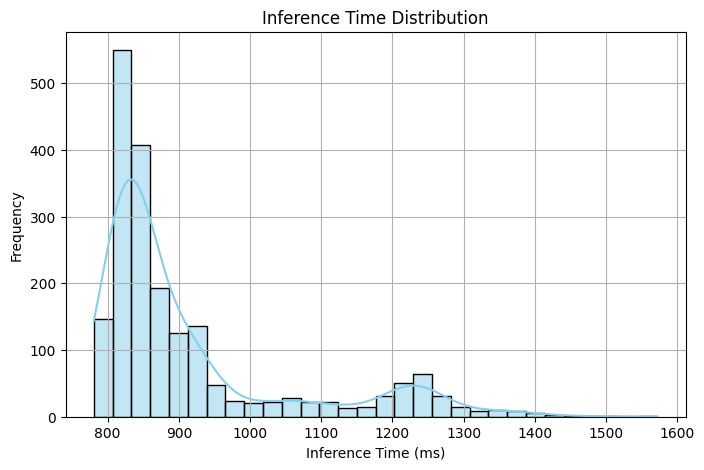

In [45]:
plt.figure(figsize=(8, 5))
sns.histplot(df["inference_time_ms"], bins=30, kde=True, color="skyblue")
plt.title("Inference Time Distribution")
plt.xlabel("Inference Time (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95th percentile of inference time: 1245.30 milliseconds


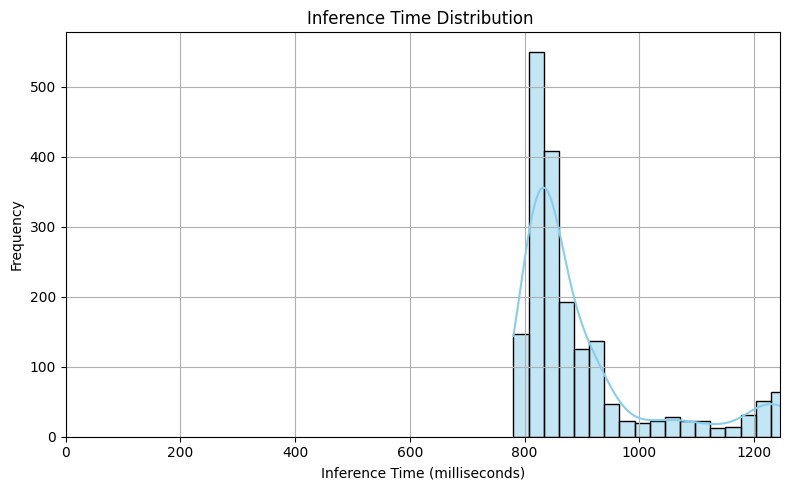

In [46]:
# Calculate the 95th percentile for inference time in ms
threshold_ms = df["inference_time_ms"].quantile(0.95)
print(f"95th percentile of inference time: {threshold_ms:.2f} milliseconds")
# Plot histogram with x-axis limited to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df["inference_time_ms"], bins=30, kde=True, color="skyblue")
plt.title("Inference Time Distribution ")
plt.xlabel("Inference Time (milliseconds)")
plt.ylabel("Frequency")
plt.xlim(0, threshold_ms)
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Calculate mean and variance of inference time
mean_inference = df["inference_time_ms"].mean()
variance_inference = df["inference_time_ms"].var()

print(f"Mean Inference Time: {mean_inference:.2f} ms")
print(f"Variance of Inference Time: {variance_inference:.2f} ms²")

Mean Inference Time: 914.06 ms
Variance of Inference Time: 20723.70 ms²


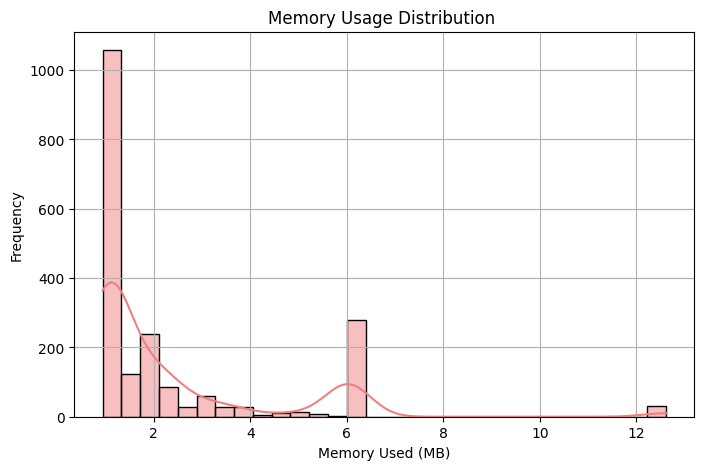

In [48]:
# 1. Full Range - Memory Usage
plt.figure(figsize=(8, 5))
sns.histplot(df["memory_used_MB"], bins=30, kde=True, color="lightcoral")
plt.title("Memory Usage Distribution ")
plt.xlabel("Memory Used (MB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95th percentile of memory usage: 6.03 MB


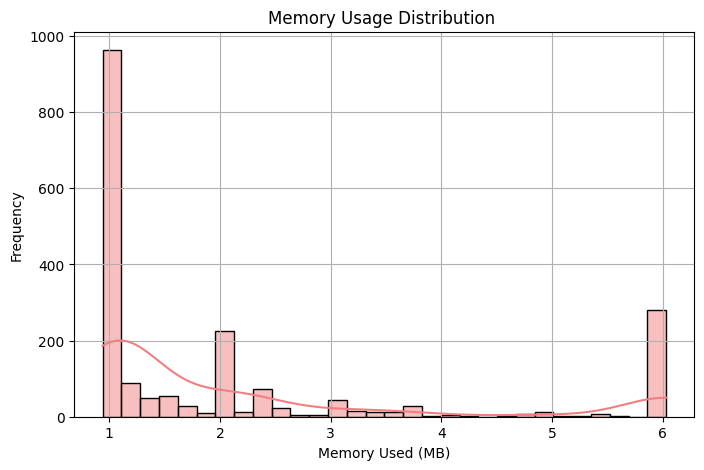

In [49]:
# Calculate the 95th percentile for memory usage
threshold_mem = df["memory_used_MB"].quantile(0.95)
print(f"95th percentile of memory usage: {threshold_mem:.2f} MB")

# Plot memory usage up to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df[df["memory_used_MB"] <= threshold_mem]["memory_used_MB"],
             bins=30, kde=True, color="lightcoral")
plt.title("Memory Usage Distribution ")
plt.xlabel("Memory Used (MB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [50]:
# Calculate mean and variance of memory usage
mean_memory = df["memory_used_MB"].mean()
variance_memory = df["memory_used_MB"].var()

print(f"Mean Memory Usage: {mean_memory:.2f} MB")
print(f"Variance of Memory Usage: {variance_memory:.2f} MB²")

Mean Memory Usage: 2.36 MB
Variance of Memory Usage: 4.60 MB²


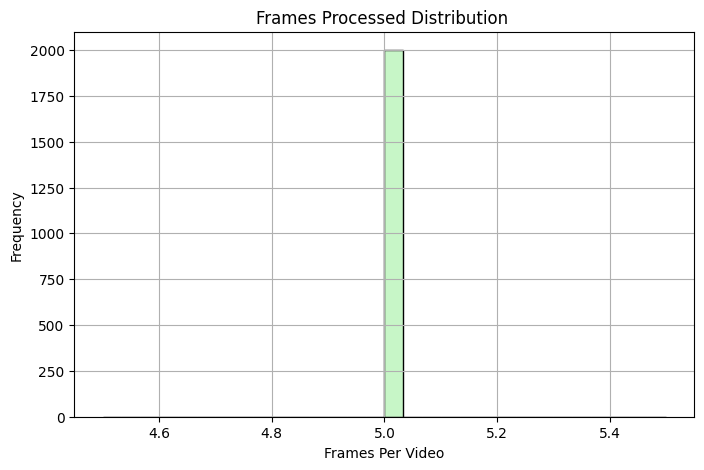

In [51]:
# 1. Full Range - Frames Processed
plt.figure(figsize=(8, 5))
sns.histplot(df["frames_processed"], bins=30, kde=True, color="lightgreen")
plt.title("Frames Processed Distribution ")
plt.xlabel("Frames Per Video")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95th percentile of frames processed: 5


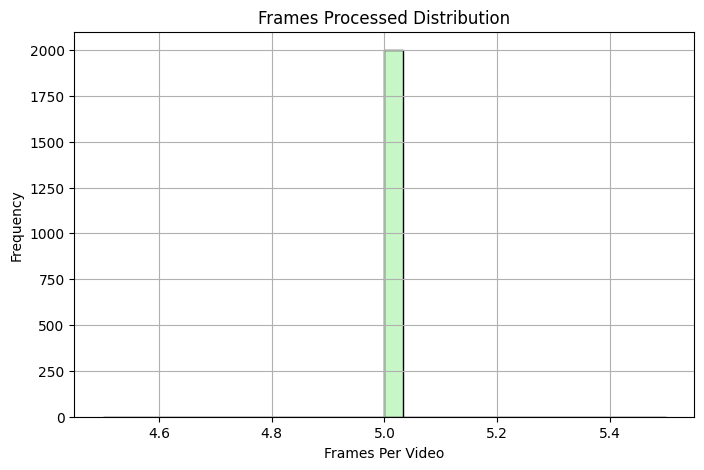

In [52]:
# Calculate the 95th percentile for frames processed
threshold_frames = df["frames_processed"].quantile(0.95)
print(f"95th percentile of frames processed: {threshold_frames:.0f}")

# Plot frames processed up to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df[df["frames_processed"] <= threshold_frames]["frames_processed"],
             bins=30, kde=True, color="lightgreen")
plt.title("Frames Processed Distribution")
plt.xlabel("Frames Per Video")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [53]:
# Calculate mean and variance of frames processed
mean_frames = df["frames_processed"].mean()
variance_frames = df["frames_processed"].var()

print(f"Mean Frames Processed: {mean_frames:.2f}")
print(f"Variance of Frames Processed: {variance_frames:.2f}")

Mean Frames Processed: 5.00
Variance of Frames Processed: 0.00


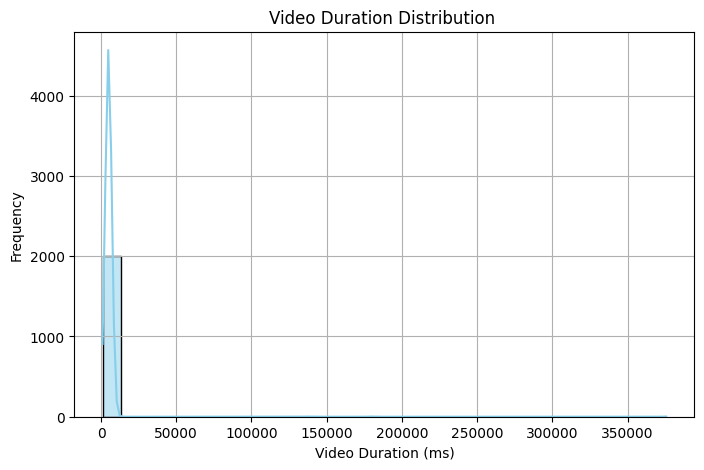

In [55]:
# Plot full range of video duration
plt.figure(figsize=(8, 5))
sns.histplot(df["duration_ms"], bins=30, kde=True, color="skyblue")
plt.title("Video Duration Distribution ")
plt.xlabel("Video Duration (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95th percentile of video duration: 5800 ms


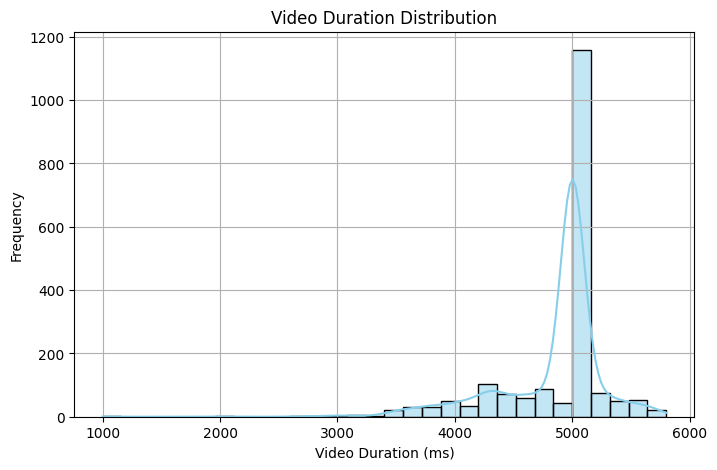

In [56]:
# Calculate the 95th percentile for video duration
threshold_duration = df["duration_ms"].quantile(0.95)
print(f"95th percentile of video duration: {threshold_duration:.0f} ms")

# Plot video duration up to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df[df["duration_ms"] <= threshold_duration]["duration_ms"],
             bins=30, kde=True, color="skyblue")
plt.title("Video Duration Distribution")
plt.xlabel("Video Duration (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [57]:
# Calculate mean and variance of video duration
mean_duration = df["duration_ms"].mean()
variance_duration = df["duration_ms"].var()

print(f"Mean Video Duration: {mean_duration:.2f} ms")
print(f"Variance of Video Duration: {variance_duration:.2f} ms²")

Mean Video Duration: 5252.81 ms
Variance of Video Duration: 93034171.96 ms²
